# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [2]:
output_featimp = 'feat_xgb_v18_count.csv'
output_sub     = 'sub_xgb_v18_count.csv'
output_oof     = 'oof_xgb_v18_count.csv'

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 10
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'count:poisson', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [4]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = train_df[TARGET]

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_3056\2301700253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_3056\2301700253.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [5]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [6]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [7]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [8]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [9]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [10]:
## OOF target
oof_nfolds = 20

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_3056\1959937025.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_3056\1959937025.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [11]:
# modeling with cross validation
kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train, y_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)
    oof_test_skf[fold_id, :] = model.predict(d_test, ntree_limit=model.best_ntree_limit)

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, y_train)))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], y_train[0:24069])))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], y_train[24069:])))


Fold 1 / 10
[0]	train-poisson-nloglik:949.27530	train-rmse:1025.93579	eval-poisson-nloglik:884.40466	eval-rmse:760.00952


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[100]	train-poisson-nloglik:858.26423	train-rmse:1025.87097	eval-poisson-nloglik:797.89381	eval-rmse:759.92657
[200]	train-poisson-nloglik:767.75588	train-rmse:1025.74158	eval-poisson-nloglik:711.87805	eval-rmse:759.76038
[300]	train-poisson-nloglik:678.02997	train-rmse:1025.48315	eval-poisson-nloglik:626.72030	eval-rmse:759.42920
[400]	train-poisson-nloglik:589.71776	train-rmse:1024.97107	eval-poisson-nloglik:543.06704	eval-rmse:758.77411
[500]	train-poisson-nloglik:503.42400	train-rmse:1023.96460	eval-poisson-nloglik:462.15351	eval-rmse:757.49988
[600]	train-poisson-nloglik:420.19726	train-rmse:1022.01154	eval-poisson-nloglik:384.92796	eval-rmse:755.05444
[700]	train-poisson-nloglik:341.22982	train-rmse:1018.28314	eval-poisson-nloglik:312.78658	eval-rmse:750.46521
[800]	train-poisson-nloglik:268.23716	train-rmse:1011.35553	eval-poisson-nloglik:247.40910	eval-rmse:742.11127
[900]	train-poisson-nloglik:202.82875	train-rmse:998.84839	eval-poisson-nloglik:190.93671	eval-rmse:727.53796
[1

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 2 / 10
[0]	train-poisson-nloglik:938.32592	train-rmse:1019.67548	eval-poisson-nloglik:982.92804	eval-rmse:832.37323
[100]	train-poisson-nloglik:848.16996	train-rmse:1019.61096	eval-poisson-nloglik:889.16598	eval-rmse:832.29114
[200]	train-poisson-nloglik:758.49228	train-rmse:1019.48193	eval-poisson-nloglik:796.18803	eval-rmse:832.12707
[300]	train-poisson-nloglik:669.61666	train-rmse:1019.22430	eval-poisson-nloglik:704.09617	eval-rmse:831.80029
[400]	train-poisson-nloglik:582.16989	train-rmse:1018.71417	eval-poisson-nloglik:613.38126	eval-rmse:831.15289
[500]	train-poisson-nloglik:496.74403	train-rmse:1017.71130	eval-poisson-nloglik:525.09146	eval-rmse:829.88586
[600]	train-poisson-nloglik:414.35189	train-rmse:1015.76556	eval-poisson-nloglik:440.85120	eval-rmse:827.45727
[700]	train-poisson-nloglik:336.17254	train-rmse:1012.05005	eval-poisson-nloglik:361.35591	eval-rmse:822.85205
[800]	train-poisson-nloglik:263.91953	train-rmse:1005.14380	eval-poisson-nloglik:289.39657	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 3 / 10
[0]	train-poisson-nloglik:951.07774	train-rmse:1032.70996	eval-poisson-nloglik:868.17375	eval-rmse:672.40625
[100]	train-poisson-nloglik:860.01737	train-rmse:1032.64563	eval-poisson-nloglik:782.11909	eval-rmse:672.31287
[200]	train-poisson-nloglik:769.45673	train-rmse:1032.51697	eval-poisson-nloglik:696.56357	eval-rmse:672.12604
[300]	train-poisson-nloglik:679.68724	train-rmse:1032.26013	eval-poisson-nloglik:611.90086	eval-rmse:671.75384
[400]	train-poisson-nloglik:591.32916	train-rmse:1031.75122	eval-poisson-nloglik:528.74896	eval-rmse:671.01776
[500]	train-poisson-nloglik:504.99326	train-rmse:1030.75085	eval-poisson-nloglik:448.10393	eval-rmse:669.58173
[600]	train-poisson-nloglik:421.72558	train-rmse:1028.80994	eval-poisson-nloglik:371.66976	eval-rmse:666.84888
[700]	train-poisson-nloglik:342.61587	train-rmse:1025.09973	eval-poisson-nloglik:300.42243	eval-rmse:661.72662
[800]	train-poisson-nloglik:269.41395	train-rmse:1018.19367	eval-poisson-nloglik:237.24742	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 4 / 10
[0]	train-poisson-nloglik:919.04408	train-rmse:847.64319	eval-poisson-nloglik:1156.41626	eval-rmse:1892.98499
[100]	train-poisson-nloglik:829.80895	train-rmse:847.56634	eval-poisson-nloglik:1053.95706	eval-rmse:1892.94531
[200]	train-poisson-nloglik:741.06926	train-rmse:847.41272	eval-poisson-nloglik:952.01789	eval-rmse:1892.86621
[300]	train-poisson-nloglik:653.11527	train-rmse:847.10608	eval-poisson-nloglik:850.98748	eval-rmse:1892.70862
[400]	train-poisson-nloglik:566.56084	train-rmse:846.49853	eval-poisson-nloglik:751.43506	eval-rmse:1892.39600
[500]	train-poisson-nloglik:482.06614	train-rmse:845.30469	eval-poisson-nloglik:654.39239	eval-rmse:1891.78284
[600]	train-poisson-nloglik:400.60122	train-rmse:842.98810	eval-poisson-nloglik:560.96097	eval-rmse:1890.59912
[700]	train-poisson-nloglik:323.40785	train-rmse:838.56616	eval-poisson-nloglik:472.53965	eval-rmse:1888.35217
[800]	train-poisson-nloglik:252.05333	train-rmse:830.33032	eval-poisson-nloglik:390.83418	eval-rmse

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 5 / 10
[0]	train-poisson-nloglik:946.32944	train-rmse:1004.41742	eval-poisson-nloglik:910.89948	eval-rmse:985.26172
[100]	train-poisson-nloglik:855.37984	train-rmse:1004.35138	eval-poisson-nloglik:823.84509	eval-rmse:985.19721
[200]	train-poisson-nloglik:764.92508	train-rmse:1004.21918	eval-poisson-nloglik:737.29652	eval-rmse:985.06824
[300]	train-poisson-nloglik:675.25889	train-rmse:1003.95544	eval-poisson-nloglik:651.63954	eval-rmse:984.81140
[400]	train-poisson-nloglik:587.00455	train-rmse:1003.43280	eval-poisson-nloglik:567.51061	eval-rmse:984.30365
[500]	train-poisson-nloglik:500.81339	train-rmse:1002.40582	eval-poisson-nloglik:485.70391	eval-rmse:983.31067
[600]	train-poisson-nloglik:417.66431	train-rmse:1000.41272	eval-poisson-nloglik:407.42098	eval-rmse:981.40204
[700]	train-poisson-nloglik:338.72712	train-rmse:996.60529	eval-poisson-nloglik:334.29983	eval-rmse:977.82239
[800]	train-poisson-nloglik:265.63106	train-rmse:989.51038	eval-poisson-nloglik:272.10628	eval-rmse:97

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 6 / 10
[0]	train-poisson-nloglik:939.16737	train-rmse:1015.04944	eval-poisson-nloglik:975.35824	eval-rmse:881.72900
[100]	train-poisson-nloglik:848.87152	train-rmse:1014.98456	eval-poisson-nloglik:882.44900	eval-rmse:881.65222
[200]	train-poisson-nloglik:759.06926	train-rmse:1014.85480	eval-poisson-nloglik:790.04380	eval-rmse:881.49829
[300]	train-poisson-nloglik:670.03788	train-rmse:1014.59552	eval-poisson-nloglik:698.58887	eval-rmse:881.19183
[400]	train-poisson-nloglik:582.44131	train-rmse:1014.08234	eval-poisson-nloglik:608.70280	eval-rmse:880.58539
[500]	train-poisson-nloglik:496.92137	train-rmse:1013.07367	eval-poisson-nloglik:521.13676	eval-rmse:879.39618
[600]	train-poisson-nloglik:414.41617	train-rmse:1011.11700	eval-poisson-nloglik:437.06200	eval-rmse:877.10010
[700]	train-poisson-nloglik:336.05117	train-rmse:1007.37946	eval-poisson-nloglik:357.81902	eval-rmse:872.74884
[800]	train-poisson-nloglik:263.53508	train-rmse:1000.42987	eval-poisson-nloglik:285.17624	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 7 / 10
[0]	train-poisson-nloglik:957.43338	train-rmse:1036.40772	eval-poisson-nloglik:810.92960	eval-rmse:618.88983
[100]	train-poisson-nloglik:865.90588	train-rmse:1036.34326	eval-poisson-nloglik:729.17521	eval-rmse:618.79358
[200]	train-poisson-nloglik:774.86334	train-rmse:1036.21436	eval-poisson-nloglik:647.97372	eval-rmse:618.60095
[300]	train-poisson-nloglik:684.59252	train-rmse:1035.95703	eval-poisson-nloglik:567.73357	eval-rmse:618.21820
[400]	train-poisson-nloglik:595.74894	train-rmse:1035.44714	eval-poisson-nloglik:489.35917	eval-rmse:617.46576
[500]	train-poisson-nloglik:508.98313	train-rmse:1034.44482	eval-poisson-nloglik:413.54846	eval-rmse:616.00049
[600]	train-poisson-nloglik:425.24884	train-rmse:1032.50000	eval-poisson-nloglik:342.10770	eval-rmse:613.22790
[700]	train-poisson-nloglik:345.72380	train-rmse:1028.78406	eval-poisson-nloglik:276.00108	eval-rmse:608.07336
[800]	train-poisson-nloglik:271.97916	train-rmse:1021.86285	eval-poisson-nloglik:216.96320	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 8 / 10
[0]	train-poisson-nloglik:962.20131	train-rmse:1038.55774	eval-poisson-nloglik:768.00931	eval-rmse:585.54565
[100]	train-poisson-nloglik:870.30751	train-rmse:1038.49329	eval-poisson-nloglik:689.46609	eval-rmse:585.44788
[200]	train-poisson-nloglik:778.91757	train-rmse:1038.36401	eval-poisson-nloglik:611.42415	eval-rmse:585.25214
[300]	train-poisson-nloglik:688.30154	train-rmse:1038.10632	eval-poisson-nloglik:534.25003	eval-rmse:584.86255
[400]	train-poisson-nloglik:599.11938	train-rmse:1037.59558	eval-poisson-nloglik:458.58795	eval-rmse:584.09302
[500]	train-poisson-nloglik:512.00217	train-rmse:1036.59131	eval-poisson-nloglik:385.27515	eval-rmse:582.59143
[600]	train-poisson-nloglik:427.91579	train-rmse:1034.64258	eval-poisson-nloglik:315.95310	eval-rmse:579.73828
[700]	train-poisson-nloglik:348.06325	train-rmse:1030.91956	eval-poisson-nloglik:252.62702	eval-rmse:574.49927
[800]	train-poisson-nloglik:273.93240	train-rmse:1023.97675	eval-poisson-nloglik:196.15433	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 9 / 10
[0]	train-poisson-nloglik:922.44832	train-rmse:961.22894	eval-poisson-nloglik:1125.86126	eval-rmse:1317.16589
[100]	train-poisson-nloglik:833.35770	train-rmse:961.16132	eval-poisson-nloglik:1022.06237	eval-rmse:1317.10840
[200]	train-poisson-nloglik:744.76817	train-rmse:961.02606	eval-poisson-nloglik:918.76054	eval-rmse:1316.99329
[300]	train-poisson-nloglik:656.94770	train-rmse:960.75610	eval-poisson-nloglik:816.34189	eval-rmse:1316.76355
[400]	train-poisson-nloglik:570.56446	train-rmse:960.22162	eval-poisson-nloglik:715.42343	eval-rmse:1316.30774
[500]	train-poisson-nloglik:486.25331	train-rmse:959.17133	eval-poisson-nloglik:616.79869	eval-rmse:1315.41125
[600]	train-poisson-nloglik:404.92988	train-rmse:957.13440	eval-poisson-nloglik:521.82961	eval-rmse:1313.67810
[700]	train-poisson-nloglik:327.79442	train-rmse:953.24725	eval-poisson-nloglik:432.47421	eval-rmse:1310.41089
[800]	train-poisson-nloglik:256.50833	train-rmse:946.03033	eval-poisson-nloglik:349.97262	eval-rmse

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 10 / 10
[0]	train-poisson-nloglik:942.55580	train-rmse:1028.23230	eval-poisson-nloglik:944.85638	eval-rmse:731.41510
[100]	train-poisson-nloglik:852.18109	train-rmse:1028.16834	eval-poisson-nloglik:852.63644	eval-rmse:731.32324
[200]	train-poisson-nloglik:762.28286	train-rmse:1028.03992	eval-poisson-nloglik:761.27185	eval-rmse:731.14001
[300]	train-poisson-nloglik:673.17267	train-rmse:1027.78381	eval-poisson-nloglik:671.06191	eval-rmse:730.77576
[400]	train-poisson-nloglik:585.41217	train-rmse:1027.27612	eval-poisson-nloglik:583.05445	eval-rmse:730.06128
[500]	train-poisson-nloglik:499.81783	train-rmse:1026.27917	eval-poisson-nloglik:498.38455	eval-rmse:728.68408
[600]	train-poisson-nloglik:417.22729	train-rmse:1024.34460	eval-poisson-nloglik:417.82811	eval-rmse:726.06006
[700]	train-poisson-nloglik:338.81830	train-rmse:1020.64972	eval-poisson-nloglik:343.65677	eval-rmse:721.20526
[800]	train-poisson-nloglik:266.16101	train-rmse:1013.76880	eval-poisson-nloglik:278.95482	eval-rmse

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



OOF RMSE: 864.3699
OOF RMSE in 0:24069:   200.7857
OOF RMSE in 24069:END: 2780.4502


Text(0, 0.5, 'actual')

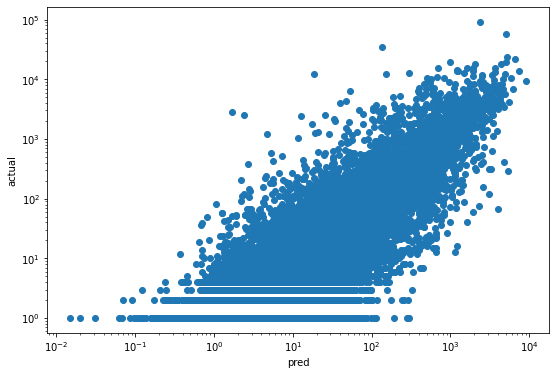

In [12]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, y_train)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

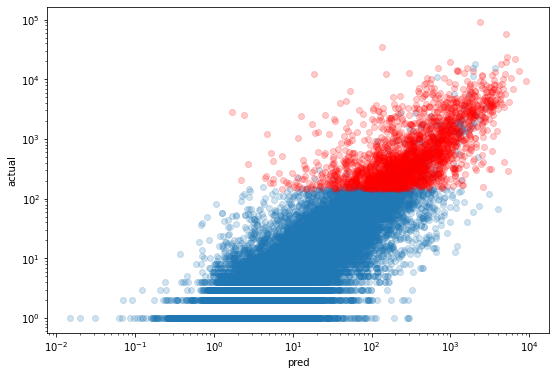

In [13]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], y_train[0:24069], alpha=0.2)
plt.scatter(oof_train[24069:], y_train[24069:], alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [14]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [15]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END